In [1]:
import pyomo.environ as pyo
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
import pandas as pd

data = pd.read_csv('Data/features_3_sec.csv')
data = data.drop(['filename'], axis=1)

data = data[data['label'].isin(['blues', 'classical'])]
# Encode the labels
y = LabelEncoder().fit_transform(data['label'])
data = data.drop(['label'], axis=1)

X = data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train_mapped = np.where(y_train == 0, -1, 1)
y_test_mapped = np.where(y_test == 0, -1, 1)

In [ ]:
n_samples, n_features = X_train.shape
model = pyo.ConcreteModel()
model.I = pyo.RangeSet(0, n_samples - 1)  # Sample indices
model.J = pyo.RangeSet(0, n_features - 1)  # Feature indices

# Parameters
def X_init(model, i, j):
    return X_train[i, j]

def y_init(model, i):
    return y_train_mapped[i]

model.X = pyo.Param(
    model.I, model.J, initialize=X_init, mutable=False, within=pyo.Reals
)
model.y = pyo.Param(
    model.I, initialize=y_init, mutable=False, within=pyo.Reals
)

model.w = pyo.Var(model.J, domain=pyo.Reals)
model.b = pyo.Var(domain=pyo.Reals)
model.xi = pyo.Var(model.I, domain=pyo.NonNegativeReals)

C = 1.0
def objective_rule(model):
    return 0.5 * model.w[j]


array([-1, -1,  1, ..., -1,  1,  1])

In [ ]:
n_samples, n_features = X_train.shape

model = pyo.ConcreteModel()
model.I = pyo.RangeSet(0, n_samples - 1)  # Sample indices
model.J = pyo.RangeSet(0, n_features - 1)  # Feature indices

def X_init(model, i, j):
    return X_train[i, j]

def y_init(model, i):
    return y_train_mapped[i]

model.X = pyo.Param(model.I, model.J, initialize=X_init, mutable=False, within=pyo.Reals)
model.y = pyo.Param(model.I, initialize=y_init, mutable=False, within=pyo.Reals)

# Variables
model.w = pyo.Var(model.J, domain=pyo.Reals)
model.b = pyo.Var(domain=pyo.Reals)
model.xi = pyo.Var(model.I, domain=pyo.NonNegativeReals)

# Penalty parameter (you can adjust C as needed)
C = 1.0

# Objective Function
def objective_rule(model):
    
    regularization = 0.5 * sum(model.w[j] ** 2 for j in model.J) + C * sum(model.xi[i] for i in model.I)
    slack = C * sum(model.xi[i]for i in model.I)
    return regularization + slack

model.Objective = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

# Constraints
def classification_constraint_rule(model, i):
    return model.y[i] * (
        sum(model.w[j] * model.X[i, j] for j in model.J) + model.b
    ) >= 1 - model.xi[i]

model.ClassificationConstraint = pyo.Constraint(
    model.I, rule=classification_constraint_rule
)


solver = pyo.SolverFactory('ipopt', executable = '/Users/aoleicao/Documents/python/6800/MacOS/ipopt')  # Replace 'ipopt' with 'gurobi', 'cplex', etc., if available
result = solver.solve(model)

w_opt = [pyo.value(model.w[j]) for j in model.J]
b_opt = pyo.value(model.b)
print("Optimal weights:", w_opt)
print("Optimal bias:", b_opt)

Optimal weights: [0.0, 0.15543648427963083, -0.44137153973531573, -0.9833858834496538, -0.8623642400911645, 0.2554349485917555, 0.026209366222519948, -0.01567355421388226, 0.3340584590538425, -0.36625991297053784, -0.2686262612627682, 1.3962789235581428, -0.3183006014707557, -0.32846699320556033, 0.6836899514408527, -0.17640356144532765, -1.5101509469366847, 0.10672613570076309, -1.1484371378020393, 0.3040891741231112, 0.09581988638001249, 0.052145735715580094, -0.7819496497350172, -0.34041675150467454, -0.4528993355332975, -1.1458291734543813, 0.45719641636535746, -0.4298734873269013, -1.3750971295517038, -1.2280457636701132, -0.1391956261371971, 0.924451247116286, -0.5961670350183839, -0.007509833556927698, 0.05725871500713502, -0.19265192755638813, 0.31342325961712336, 0.4277206402651838, -0.05517570271898616, -0.07254224147040532, -0.36225061226603084, 0.25159738314360786, 0.4977534721868224, 0.16665131078162487, -0.7100582198895198, 0.5475350562852614, 0.7723199883000433, -0.66797

In [ ]:
# Make predictions on the test set
decision_values = np.dot(X_test, w_opt) + b_opt
predictions = np.sign(decision_values)

# Map any zero predictions to 1 (could also map to -1; adjust as needed)
predictions[predictions == 0] = 1

# Calculate accuracy
accuracy = np.mean(predictions == y_test_mapped)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.9875


In [8]:
# Generate a classification report
from sklearn.metrics import classification_report

print(classification_report(y_test_mapped, predictions))

# -------------------------------------------------
# Optional: Compare with scikit-learn's SVM
# -------------------------------------------------

from sklearn.svm import SVC

# Initialize and train the SVM classifier
svm_classifier = SVC(C=1.0, kernel='linear')
svm_classifier.fit(X_train, y_train_mapped)

# Predict on the test data
y_pred = svm_classifier.predict(X_test)

# Evaluate the scikit-learn SVM model
print("scikit-learn SVM Classification Report:")
print(classification_report(y_test_mapped, y_pred))
print("scikit-learn SVM Test Accuracy:", accuracy_score(y_test_mapped, y_pred))

# Extract the parameters from scikit-learn's model
w_sklearn = svm_classifier.coef_[0]
b_sklearn = svm_classifier.intercept_[0]

print("Weights from scikit-learn SVM:", w_sklearn)
print("Bias from scikit-learn SVM:", b_sklearn)

              precision    recall  f1-score   support

          -1       0.98      1.00      0.99       207
           1       0.99      0.98      0.99       193

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400

scikit-learn SVM Classification Report:
              precision    recall  f1-score   support

          -1       0.98      1.00      0.99       207
           1       0.99      0.98      0.99       193

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400

scikit-learn SVM Test Accuracy: 0.9875
Weights from scikit-learn SVM: [ 0.          0.07147759 -0.48076908 -0.83736119 -0.51211001  0.15773875
 -0.11801469  0.11365314  0.19694931 -0.35878724 -0.13938376  1.09846349
 -0.22805021 -0.3039283   0.40187195 -0.06715883 -1.21009914  0.08723802
 -0.92893879  0.3

In [9]:
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train)
X_test_2d = pca.transform(X_test)

# Update the Pyomo model for 2D data
n_samples, n_features = X_train_2d.shape

# Initialize the Pyomo model for 2D data
model = pyo.ConcreteModel()

# Sets
model.I = pyo.RangeSet(0, n_samples - 1)  # Set of samples
model.J = pyo.RangeSet(0, n_features - 1)  # Set of features

# Parameters
def X_init_2d(model, i, j):
    return X_train_2d[i, j]  # 2D Training features

model.X = pyo.Param(model.I, model.J, initialize=X_init_2d, within=pyo.Reals)
model.y = pyo.Param(model.I, initialize=y_init, within=pyo.Reals)

# Variables
model.w = pyo.Var(model.J, domain=pyo.Reals)  # Weight vector
model.b = pyo.Var(domain=pyo.Reals)  # Bias term
model.xi = pyo.Var(model.I, domain=pyo.NonNegativeReals)  # Slack variables (xi_i)

# Objective Function
def objective_rule(model):
    regularization_term = 0.5 * sum(model.w[j] ** 2 for j in model.J)
    slack_penalty = C * sum(model.xi[i] for i in model.I)
    return regularization_term + slack_penalty

model.Objective = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

# Constraints
def classification_constraints(model, i):
    return model.y[i] * (
        sum(model.w[j] * model.X[i, j] for j in model.J) + model.b
    ) >= 1 - model.xi[i]

model.ClassificationConstraint = pyo.Constraint(
    model.I, rule=classification_constraints
)
solver = pyo.SolverFactory('ipopt', executable = '/Users/aoleicao/Documents/python/6800/MacOS/ipopt')  # Replace 'ipopt' with 'gurobi', 'cplex', etc., if available
result = solver.solve(model)

w_opt = [pyo.value(model.w[j]) for j in model.J]
b_opt = pyo.value(model.b)
print("Optimal weights:", w_opt)
print("Optimal bias:", b_opt)


Optimal weights: [-0.6066823996869792, -0.24399100592040338]
Optimal bias: -0.008657863881650829


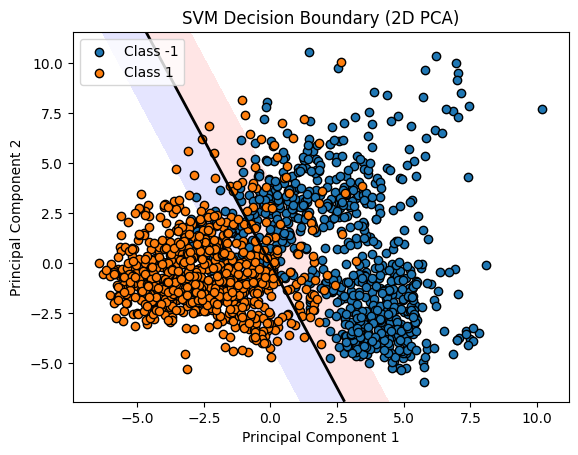

In [ ]:
x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))

Z = np.dot(np.c_[xx.ravel(), yy.ravel()], w_opt) + b_opt
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, levels=[-1, 0, 1], alpha=0.3, colors=["#FFAAAA", "#AAAAFF"])
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="k")

for i, label in enumerate(np.unique(y_train_mapped)):
    plt.scatter(
        X_train_2d[y_train_mapped == label, 0],
        X_train_2d[y_train_mapped == label, 1],
        label=f"Class {label}",
        edgecolor="k"
    )

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("SVM Decision Boundary (2D PCA)")
plt.legend()
plt.show()

In [ ]:
s

(9990, 58)


In [19]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
models = []
n_samples, n_features = 
for k in range(10):
    y_train_k = np.where(y_train == k, 1, -1)
    model = pyo.ConcreteModel()

    model.I = pyo.RangeSet(0, n_samples - 1)  # Sample indices
    model.J = pyo.RangeSet(0, n_features - 1)  # Feature indices
    